In [1]:
import numpy as np
import matplotlib.pyplot as plt
import MDAnalysis as mda
import time
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from trimesh.creation import *

from swipes.isosurface import isosurface
import matplotlib.tri as mtri
from skimage import measure

from skimage.draw import ellipsoid
import matplotlib
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import floyd_warshall
from scipy.optimize import curve_fit
%matplotlib notebook

# Circle calculation

In [116]:
f = open("sample_sphere.ply","r")
lines = f.readlines()
lines = np.array([[float(f) for f in l.rstrip("\n").split()] for l in lines])
f.close()
coords = lines[:,:3]
normals = lines[:,3:6]

f = open("triangle_indices.ply","r")
lines = f.readlines()
lines = np.array([[int(f) for f in l.rstrip("\n").split()] for l in lines])
f.close()
triangle_indices = lines[:,1:]

<IPython.core.display.Javascript object>


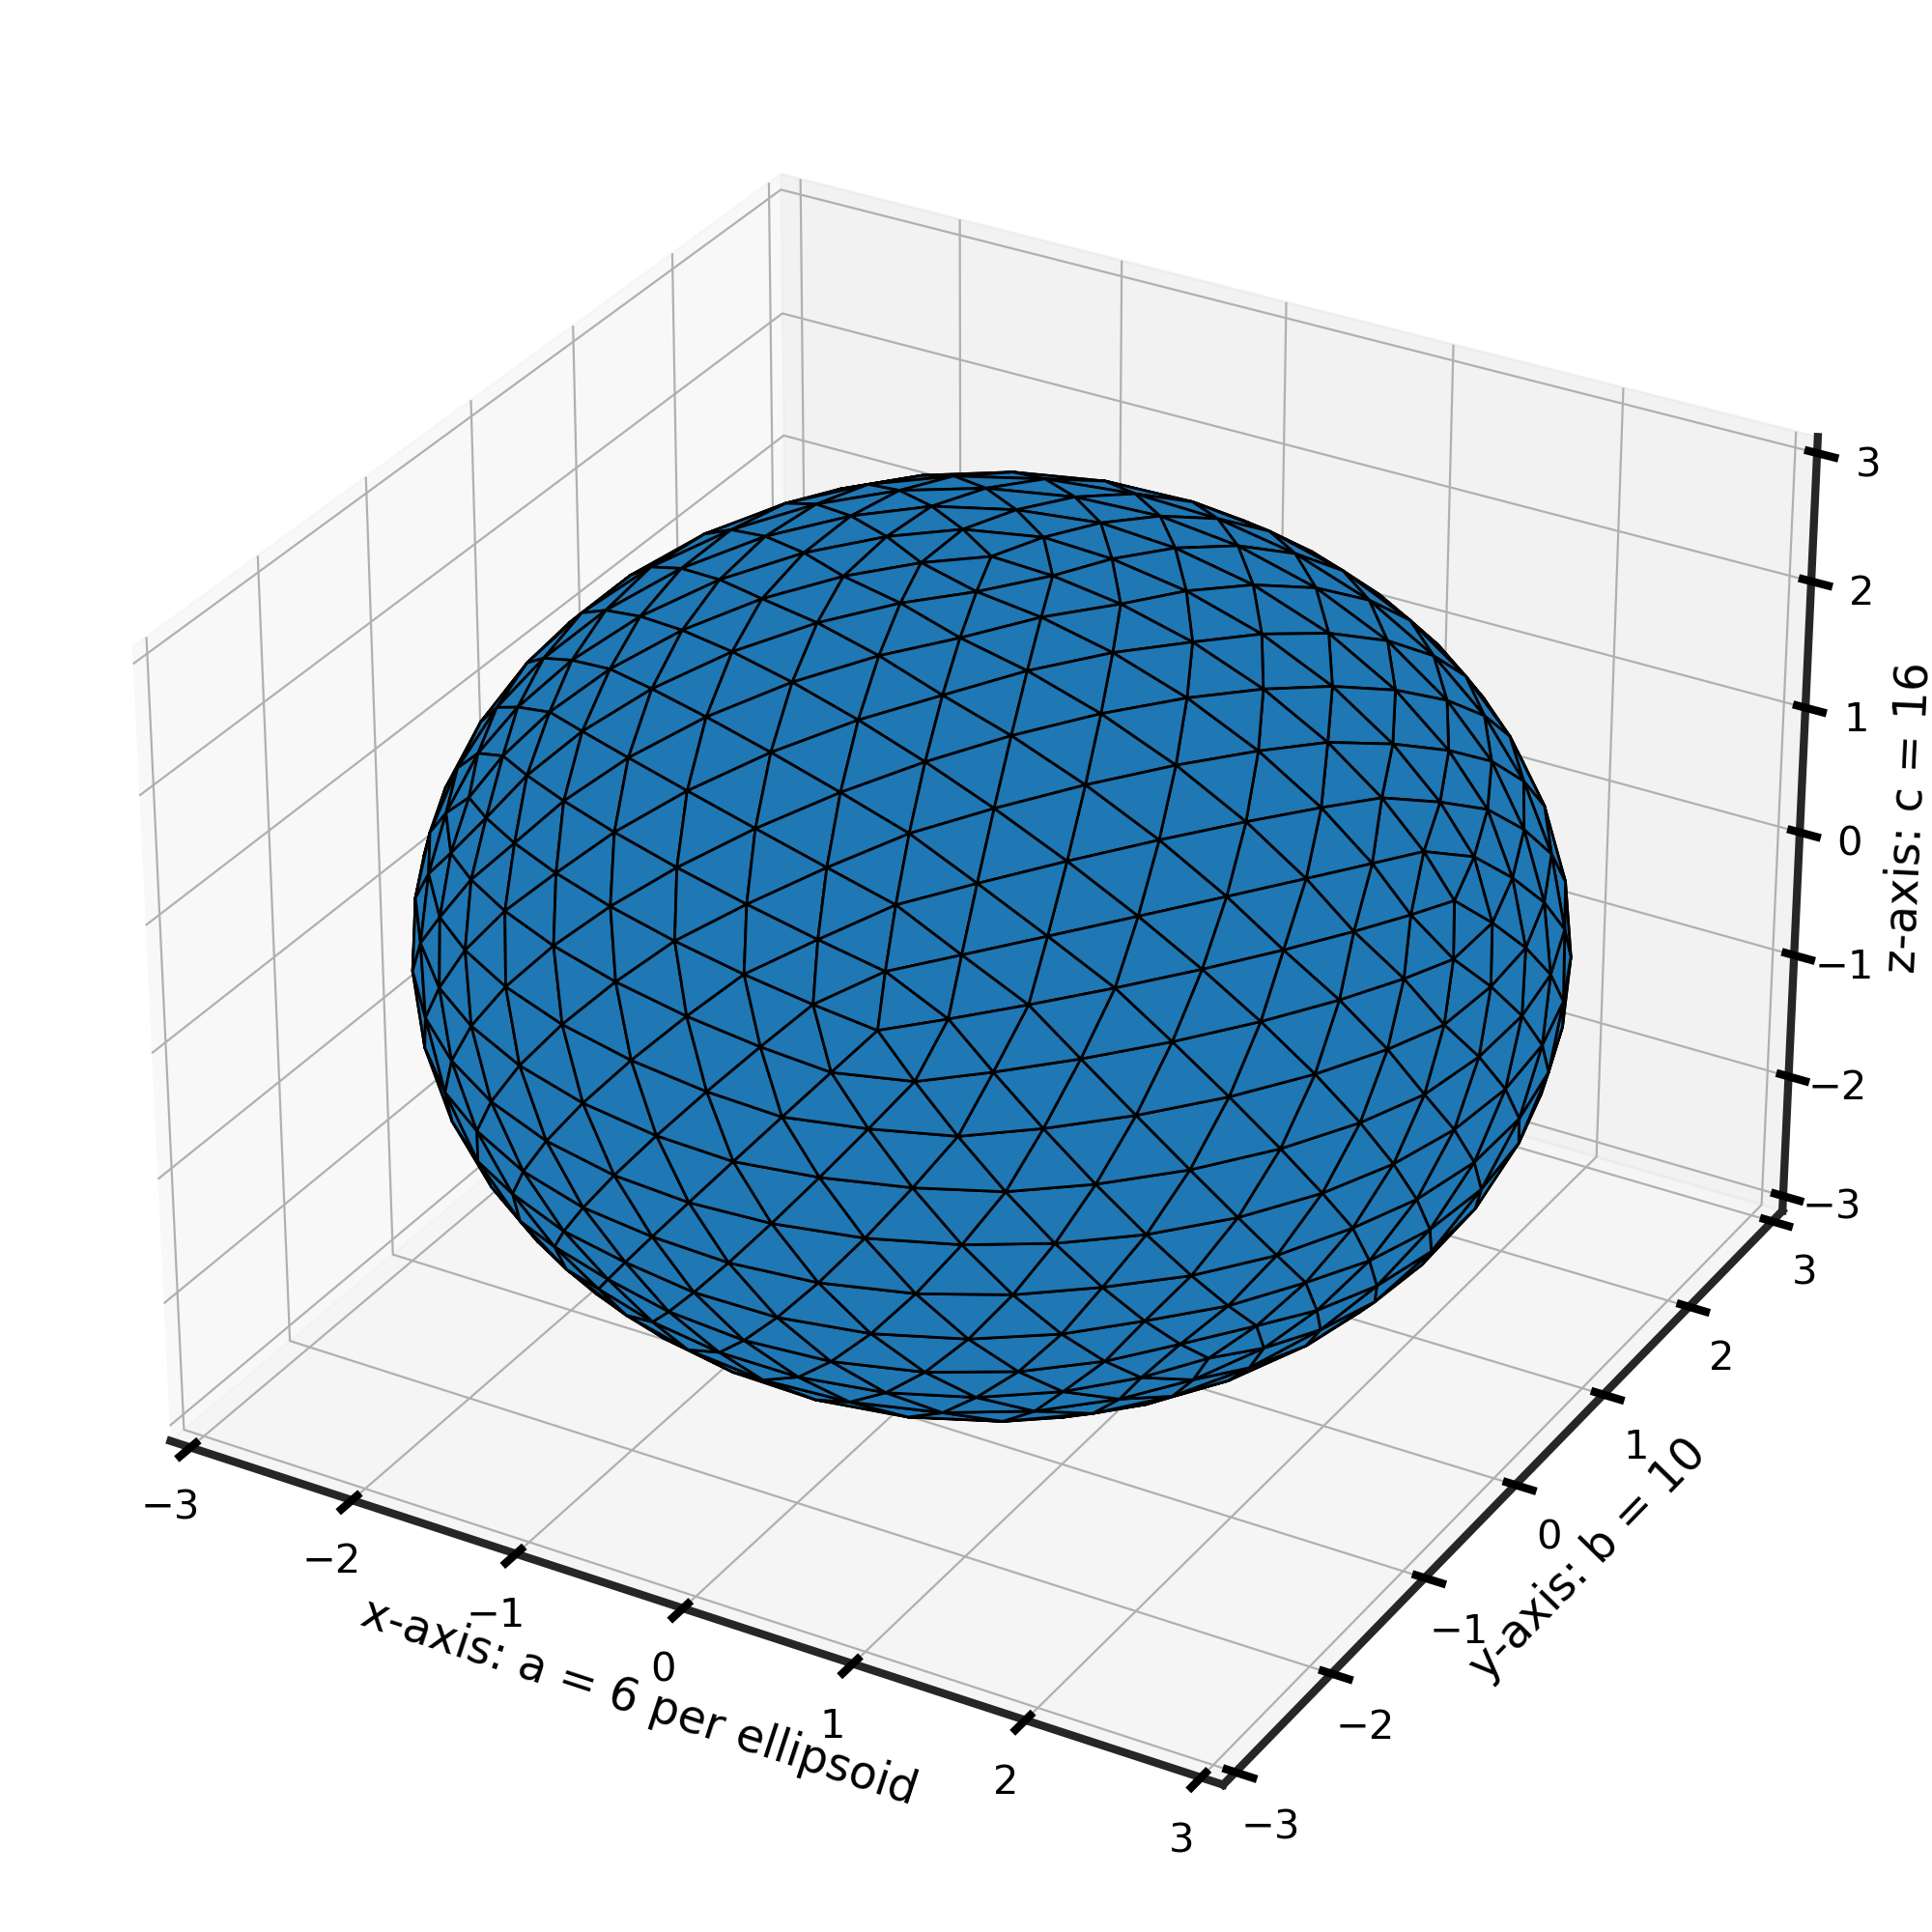

In [119]:
# Display resulting triangular mesh using Matplotlib. This can also be done
# with mayavi (see skimage.measure.marching_cubes_lewiner docstring).
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')


# Fancy indexing: `verts[faces]` to generate a collection of triangles
mesh = Poly3DCollection(coords[triangle_indices])
mesh.set_edgecolor('k')
ax.add_collection3d(mesh)


ax.set_xlabel("x-axis: a = 6 per ellipsoid")
ax.set_ylabel("y-axis: b = 10")
ax.set_zlabel("z-axis: c = 16")


ax.set_xlim(-3,3)  # a = 6 (times two for 2nd ellipsoid)
ax.set_ylim(-3,3)  # b = 10
ax.set_zlim(-3,3)  # c = 16

plt.tight_layout()
plt.show()

# Least Squares solution

In [ ]:
edge1 = coords[triangle_indices[:,2]] - coords[triangle_indices[:,1]]
edge2 = coords[triangle_indices[:,0]] - coords[triangle_indices[:,2]]
edge3 = coords[triangle_indices[:,1]] - coords[triangle_indices[:,0]]

normaldiff0 = normals[triangle_indices[:,2]] - normals[triangle_indices[:,1]]
normaldiff1 = normals[triangle_indices[:,0]] - normals[triangle_indices[:,2]]
normaldiff2 = normals[triangle_indices[:,1]] - normals[triangle_indices[:,0]]

# find per face coordinates
U = edge1/np.sqrt((edge1**2).sum(axis=1,keepdims=True))
N = np.cross(edge1, edge2)
TriangleAreas = np.sqrt((N**2).sum(axis=1,keepdims=True))
N = N/np.sqrt((N**2).sum(axis=1,keepdims=True))
V = np.cross(U,N)

# finding per vertex normals
vertexnormals = np.zeros((coords.shape[0],3))
for i in range(triangle_indices.shape[0]):
    t = triangle_indices[i]
    vertexnormals[t[0]] = coords[t[1]] - coords[t[0]]
    vertexnormals[t[1]] = coords[t[2]] - coords[t[1]]
    vertexnormals[t[2]] = coords[t[0]] - coords[t[2]]


vertexnormals = np.cross(vertexnormals, normals)
vertexnormals = vertexnormals/np.sqrt((vertexnormals**2).sum(axis=1,keepdims=True))
vertexnormals2 = np.cross(vertexnormals, normals)

matTot = np.zeros((triangle_indices.shape[0],3,3))
for i in range(triangle_indices.shape[0]):
    mat = np.zeros((3,3))
    b = np.zeros((3,1))
    
    e1U = np.dot(edge1[i], U[i])
    e2U = np.dot(edge2[i], U[i])
    e3U = np.dot(edge3[i], U[i])
    
    eU = np.array([e1U, e2U, e3U])
    #print(eU)
    e1V = np.dot(edge1[i], V[i])
    e2V = np.dot(edge2[i], V[i])
    e3V = np.dot(edge3[i], V[i])
    
    eV = np.array([e1V, e2V, e3V])
    #print(eV)
    mat[0,0] = (eU*eU).sum()
    mat[0,1] = (eU*eV).sum()
    mat[2,2] = (eV*eV).sum()
    
    mat[1,1] = mat[0,0] + mat[2,2]
    mat[1,0] = mat[0,1]
    mat[1,2] = mat[0,1]
    mat[2,1] = mat[1,2]
    
    
    normD = np.vstack((normaldiff0[i], normaldiff1[i],normaldiff2[i]))

    normDU = (normD*U[i]).sum(axis=1)
    normDV = (normD*V[i]).sum(axis=1)
    
    b[0] = (normDU*eU).sum()
    b[1] = (normDU*eV).sum() + (normDV*eU).sum()
    b[2] = (normDV*eV).sum()
    
    invmat = np.linalg.inv(mat)
    ans = np.dot(invmat, b)
    
    II = np.zeros((2,2))
    II[0,0] = ans[0]
    II[1,1] = ans[2]
    II[1,0] = ans[1]
    II[0,1] = ans[1]
    
    eig,eigv = np.linalg.eig(II)
    print(eig)

In [ ]:
# calculate triangle areas
points = coords[triangle_indices]
side1 = points[:,1] - points[:,0]
side2 = points[:,0] - points[:,2]
area = np.sqrt((np.cross(side1,side2)**2).sum(axis=1))/2
neighbors = [[] for _ in range(coords.shape[0])]

vertex_neighbor_area = np.zeros((coords.shape[0],))
vertex_matrix = np.zeros((coords.shape[0],3,3))

for (i,val) in enumerate(points):
    # index of the triangles in the vertex data
    t = faces[i]
    A = area[i]
    print(i)
    for j in range(3):
        norm = normals[t[j]]
        vert = coords[t[j]]
        dyad = np.outer(norm, norm)
        tangential = np.eye(3) - dyad
        for k in range(3):
            if (j != k):
                if t[k] not in neighbors[t[j]]:
                    diff =  coords[t[k]] - vert
                    diffsq = (diff**2).sum()

                    kappa = 2* np.dot(diff, norm)/diffsq
                    T = np.dot(tangential, diff)
                    T = T/np.sqrt((T**2).sum())

                    matrix = A*kappa*np.outer(T,T)
                    vertex_matrix[t[j]] += matrix         
                    vertex_neighbor_area[t[j]] += A
                    
                    neighbors[t[j]].append(t[k])

In [ ]:
Id = getNearbyIndicesTriangularMesh(coords,triangle_indices)
N = findNeighborsNVertexAway(Id, 2)

In [ ]:
vertex_neighbor_area[-1]

In [ ]:
ix = 200

q = vertex_matrix[ix]/vertex_neighbor_area[ix]
print(q)
E = np.array([1,0,0])

norm1 = ((E - normals[ix])**2).sum()
norm2 = ((E + normals[ix])**2).sum()

if (norm2 > norm1):
    sign = 1
else:
    sign = -1
    
W = E + sign*normals[ix]
W = W / np.sqrt((W**2).sum())
Q = np.eye(3) - 2*np.outer(W,W)
l = Q.T.dot(q).dot(Q)
sub = l[1:,1:]
eig,eigv = np.linalg.eig(sub)
k1 = 3*eig[1] - eig[0]
k2 = 3*eig[0] - eig[1]
print("eig0 = ", eig[0])
print("eig1 = ", eig[1])
print("k1 = ", k1)
print("k2 = ", k2)
print("mean curvature = ", 1/2*(k1+k2))

In [ ]:
tri = [[] for _ in range(verts.shape[0])]

for i in range(faces.shape[0]):
    t = faces[i]
    for j in range(3):
        id1 = t[j]
        for k in range(3):
            if j != k:
                id2 = t[k]
                if id2 not in tri[id1]:
                    tri[id1].append(id2)

In [ ]:
for i in range(verts.shape[0]):
    v = verts[i]
    T = np.eye(3) - np.outer(normals[i], normals[i])
    
    for j in range(len(tri[i])):
        diff = verts[tri[i][j]] - v
        if diff.sum() != 0:
            difftrans = np.dot(T, diff)
            difftrans = difftrans/np.sqrt((difftrans**2).sum())
            print(difftrans)

## Circle Calculation sub part

In [ ]:
def getNearbyIndicesTriangularMesh(coordinates, triangleID):
    nearby_indices = [[] for _ in range(coordinates.shape[0])]
    for i in range(triangleID.shape[0]):
        t = triangle_indices[i]
        for j in range(3):
            id1 = t[j]
            for k in range(3):
                if j != k:
                    id2 = t[k]
                    if id2 not in nearby_indices[id1]:
                        nearby_indices[id1].append(id2)
    return nearby_indices

In [ ]:
def findNeighborsNVertexAway(NearbyIndices, N:int):
    Neighbors = [[] for _ in range(len(NearbyIndices))]
    
    for i in range(len(Neighbors)):
        initial_count = 0
        final_count = 0
        for j in range(N):
            if len(Neighbors[i]) == 0:
                Neighbors[i] += NearbyIndices[i]
                final_count = len(Neighbors[i])
            else:
                tempIndices = []
                for k in range(initial_count, final_count):
                    tempIndices += NearbyIndices[Neighbors[i][k]]
                Neighbors[i] += tempIndices
                intial_count = final_count
                final_count = len(Neighbors[i])
    return Neighbors

def rotationMatrix(vec1, vec2):
    """
    rotation matrix that rotates vec1 onto vec2
    """
    vec1n  = vec1/np.sqrt((vec1**2).sum())
    vec2n  = vec2/np.sqrt((vec2**2).sum())
    cross = np.cross(vec1n, vec2n)
    sin2 = (cross**2).sum()
    if sin2 > 1e-10:
        sine  = np.sqrt((cross**2).sum())
    else:
        return np.eye(3)
    
    cosine= np.dot(vec1n, vec2n)
    
    v = np.zeros((3,3))
    v[0,1] = -cross[2]
    v[0,2] = cross[1]
    v[1,0] = cross[2]
    v[1,2] = -cross[0]
    v[2,0] = -cross[1]
    v[2,1] = cross[0]

    R = np.eye(3) + v + np.dot(v,v)*1/(1+cosine)
    
    return R

def CalculateCurvature(vertices, triangle_indices, num_neighbors):
    Id = getNearbyIndicesTriangularMesh(vertices, triangle_indices)
    N = findNeighborsNVertexAway(Id, num_neighbors)
    
    mat = np.zeros((vertices.shape[0],2,2))
    eig = np.zeros((vertices.shape[0],2))
    
    def SecondFundamentalForm(X, L, M, N):
        dx = X[:,0]
        dy = X[:,1]

        return L*(dx**2)/2 + 2*M*(dx*dy) + N*dy**2/2
    
    for i in range(vertices.shape[0]):
        neighbors = N[i]
        neighborsnp = np.array(neighbors).astype(int)
        neighborsnp = np.unique(neighborsnp)
        print(neighborsnp)
        verts = vertices[neighborsnp]
        vert = vertices[i]

        diff  = verts - vert
        n = normals[i]
        zaxis = np.array([0,0,1])
        
        R = rotationMatrix(n,zaxis)

        trans = np.matmul(R,diff.T)
        trans = trans.T
        popt, pcov = curve_fit(SecondFundamentalForm, trans[:,:2],trans[:,2],)
        mat[i][0,0] = popt[0]
        mat[i][1,1] = popt[2]
        mat[i][0,1] = popt[1]
        mat[i][1,0] = popt[1]

        e, ev = np.linalg.eig(mat[i])
        eig[i,0] = e[0]
        eig[i,1] = e[1]
    return eig

In [ ]:
CalculateCurvature(coords,triangle_indices,2)

# AFP calculations

In [ ]:
f = open("test5400.out","r")
lines = f.readlines()
data = lines[0].split()
data = [float(a) for a in data]
f.close()
fielddata = data

f = open("vertex5400.out","r")
lines = f.readlines()
lines = [l.lstrip().rstrip("\n").split() for l in lines]
lines = np.array([[float(k) for k in l] for l in lines])
f.close()
vertices = lines

f = open("triangle5400.out","r")
lines = f.readlines()
lines = [l.lstrip().rstrip("\n").split() for l in lines]
lines = np.array([[int(k) for k in l] for l in lines])
f.close()
triangle_indices = lines

f = open("normals5400.out","r")
lines = f.readlines()
lines = [[float(f) for f in l.lstrip("\n").split()] for l in lines]
f.close()
normals = np.array(lines)

f = open("curve5400.out","r")
lines = f.readlines()
lines = [[float(f) for f in l.lstrip("\n").split()] for l in lines if not l.startswith("#")]
f.close()
curvedata = np.array(lines)

In [ ]:
cuve = CalculateCurvature(vertices, triangle_indices, 2)

## Calculate using vertex fitting 

In [ ]:
curve_select = curvedata[vertices[:,0]>7]

In [ ]:
points = vertices[triangle_indices]
# Display resulting triangular mesh using Matplotlib. This can also be done
# with mayavi (see skimage.measure.marching_cubes_lewiner docstring).
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Fancy indexing: `verts[faces]` to generate a collection of triangles
mesh = Poly3DCollection(points)
mesh.set_edgecolor('k')
ax.add_collection3d(mesh)

ax.set_xlabel("x-axis: a = 6 per ellipsoid")
ax.set_ylabel("y-axis: b = 10")
ax.set_zlabel("z-axis: c = 16")

ax.set_xlim(0, 10)  # a = 6 (times two for 2nd ellipsoid)
ax.set_ylim(0, 10)  # b = 10
ax.set_zlim(0, 10)  # c = 16

plt.tight_layout()
plt.show()

In [ ]:
GCurve = curve_select[:,0] * curve_select[:,1]
curve_select

In [ ]:
np.abs(Gselect).mean()

In [ ]:
idx = np.argwhere(vertices[:,0] >7)
idx = idx.flatten()
vert_select = vertices[idx]
curve_select = curvedata[vertices[:,0]>7]
points = vertices[triangle_indices]
p = points.reshape(-1,3)

fig = plt.figure()
ax = plt.axes(projection ='3d')  

Gselect = 1/2*(curve_select[:,0]+curve_select[:,1])

m = ax.scatter(vert_select[:,0],vert_select[:,1],vert_select[:,2],vmin=0,vmax=1, c=np.abs(Gselect),cmap='RdBu')
ax.set_xlim(0,10)
cbar = fig.colorbar(m)

In [ ]:
neighbors = [[] for _ in range(vertices.shape[0])]
curvatureVal = [[] for _ in range(vertices.shape[0])]
curvaturevalue = np.ones((vertices.shape[0],))
neighbornums = np.zeros((vertices.shape[0],))

for i in range(triangle_indices.shape[0]):
    t = triangle_indices[i]
    
    for j in range(3):
        i1 = t[j]
        for k in range(j+1,3):
            i2 = t[k]
            if i2 not in neighbors[i1]:
                diff = vertices[i1] - vertices[i2]
                diffsq = (diff**2).sum()

                n1 = normals[i1]
                n2 = normals[i2]

                diffn = n1 - n2

                dotproduct = np.dot(diffn, diff)
                val = dotproduct/diffsq

                curvatureVal[i1].append(val)
                curvatureVal[i2].append(val)
                neighbors[i1].append(i2)
                neighbors[i2].append(i1)
                neighbornums[i1] += 1
                neighbornums[i2] += 1
                curvaturevalue[i1] *= abs(val)
                curvaturevalue[i2] *= abs(val)
curvaturevalue = curvaturevalue**(1/neighbornums)

In [ ]:
ix = np.argwhere(vertices[:,0] > 3.2)
c = curvaturevalue[ix]

In [ ]:
curvatureVal

In [ ]:
triangle_indices[12270]

In [ ]:
np.argwhere(triangle_indices == 6236)

In [ ]:
vertices[6236]

In [ ]:
normals[6236]

In [ ]:
# calculate triangle areas
points = vertices[triangle_indices]
side1 = points[:,1] - points[:,0]
side2 = points[:,0] - points[:,2]
area = np.sqrt((np.cross(side1,side2)**2).sum(axis=1))/2


vertex_neighbor_area = np.zeros((vertices.shape[0],))
vertex_matrix = np.zeros((vertices.shape[0],3,3))

for (i,val) in enumerate(points):
    # index of the triangles in the vertex data
    t = triangle_indices[i]
    A = area[i]
    print(i)
    for j in range(3):
        norm = normals[t[j]]
        vert = vertices[t[j]]
        dyad = np.outer(norm, norm)
        tangential = np.eye(3) - dyad
        for k in range(3):
            if (j != k):
                diff = vertices[t[k]] - vert
                diffsq = (diff**2).sum()
                
                k = 2* np.dot(diff, norm)/diffsq
                T = np.dot(tangential, diff)
                T = T/np.sqrt((T**2).sum())
                
                matrix = A*k*np.outer(T,T)
                vertex_matrix[t[j]] += matrix         
                vertex_neighbor_area[t[j]] += A

In [ ]:
idx[50]

In [ ]:
vertices[50]

In [ ]:
idx = np.argwhere(vertices[:,0] > 3.2)

In [ ]:
ix = 89

l = vertex_matrix[ix]/vertex_neighbor_area[ix]
x = np.array([1,0,0])
E1 = (x - normals[ix])
E1 = E1/np.sqrt((E1**2).sum())
Q = np.eye(3) - 2*np.outer(E1,E1)
res = (Q.T).dot(l).dot(Q)
eigv, eigvec = np.linalg.eig(res[1:,1:])
k1 = 3*eigv[0] - eigv[1]
k2 = 3*eigv[1] - eigv[0]
print("k1 = ", k1)
print("k2 = ", k2)

In [ ]:
np.linalg.eig(l)

# Catmull–Clark subdivision surface

<IPython.core.display.Javascript object>


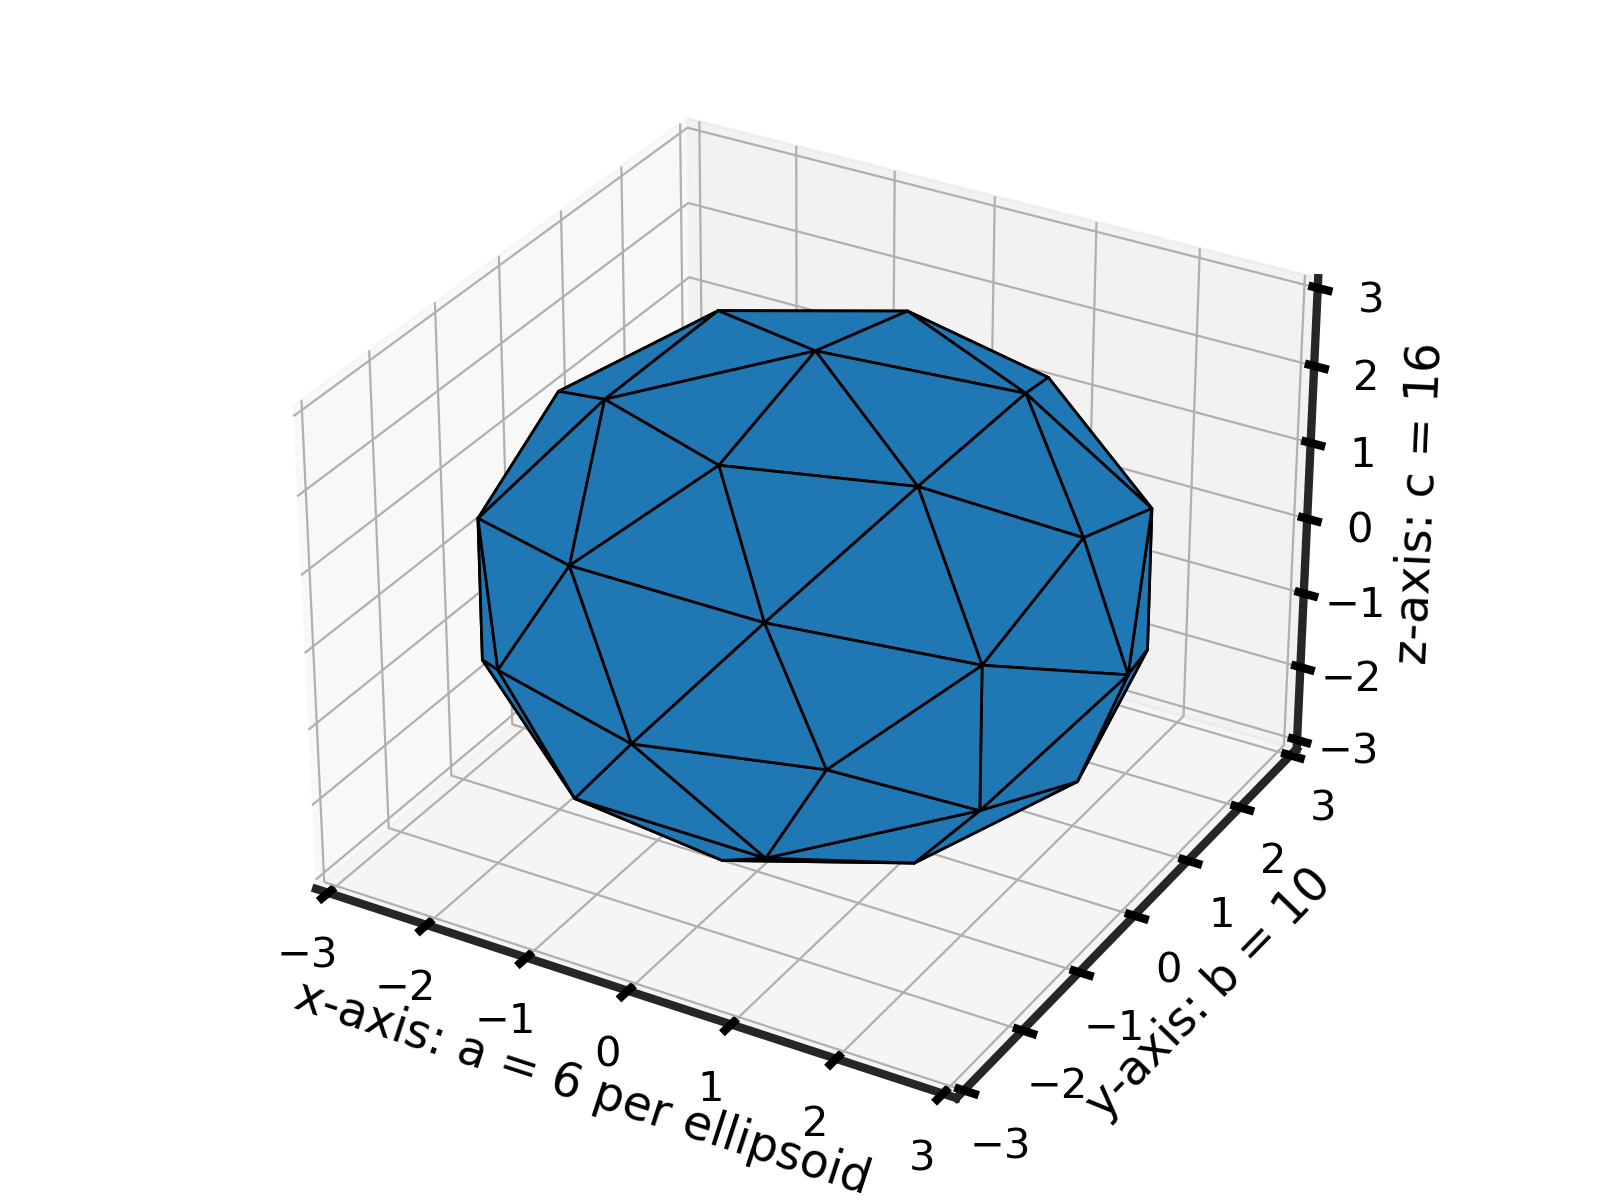

In [22]:
s = icosphere(subdivisions=1,radius=3)
vert = s.vertices
triangle_indices = s.faces
# Display resulting triangular mesh using Matplotlib. This can also be done
# with mayavi (see skimage.measure.marching_cubes_lewiner docstring).
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')


# Fancy indexing: `verts[faces]` to generate a collection of triangles
mesh = Poly3DCollection(vert[triangle_indices])
mesh.set_edgecolor('k')
ax.add_collection3d(mesh)


ax.set_xlabel("x-axis: a = 6 per ellipsoid")
ax.set_ylabel("y-axis: b = 10")
ax.set_zlabel("z-axis: c = 16")


ax.set_xlim(-3,3)  # a = 6 (times two for 2nd ellipsoid)
ax.set_ylim(-3,3)  # b = 10
ax.set_zlim(-3,3)  # c = 16

plt.tight_layout()
plt.show()

In [44]:
def getFacePoints(coords:np.ndarray, faces:np.ndarray):
    pos = coords[faces].sum(axis=1)
    pos /= 3
    
    return pos

def AppendToDic(index1, index2, value, dic):
    sorted_ = np.sort([index1,index2])
    sorted_set = (sorted_[0],sorted_[1])
    
    if sorted_set in dic:
        dic[sorted_set].append(value)
    else:
        dic[sorted_set] = [ value ]

def getFacesOfVertex(coords:np.ndarray, faces:np.ndarray):
    list_ = [[] for _ in range(coords.shape[0])]
    
    for (i,f) in enumerate(faces):
        for fi in f:
            list_[int(fi)].append(i)
    
    return list_
    
def getEdges(coords:np.ndarray, faces:np.ndarray):
    """
    Function that maps edges to the faces that it is a part of
    Thinking of a dictionary structure that looks like the following 
    
    dic["index1-index2"] = index of face
    """
    edgeDic = {}
    
    for (i,f) in enumerate(faces):
        #check if edge 1 is in the edge Dic
        AppendToDic(f[0],f[1],i, edgeDic)
        AppendToDic(f[1],f[2],i, edgeDic)
        AppendToDic(f[2],f[0],i, edgeDic)
    
    return edgeDic

def getEdgePoints(coords:np.ndarray, faces:np.ndarray, facePoints:np.ndarray):
    edgeDic = getEdges(coords, faces)
    edgePoints = np.zeros((len(edgeDic),3))
    for (i,d) in enumerate(edgeDic):
        Faces = np.array(edgeDic[d])
        index1 = d[0]
        index2 = d[1]
        
        edgesC = 1/2*(coords[index1] + coords[index2])
        avgFP = facePoints[Faces].sum()/len(Faces)
        EdgeP = 0.5*(edgesC + avgFP)
        edgePoints[i] = EdgeP
    return edgeDic,edgePoints

def getavgMidEdges(coords:np.ndarray, faces:np.ndarray):
    pos = coords[faces]
    
    edge1 = 1/2*(pos[:,0,:] + pos[:,1,:])
    edge2 = 1/2*(pos[:,1,:] + pos[:,2,:])
    edge3 = 1/2*(pos[:,2,:] + pos[:,0,:])
    
    MidEdges = np.zeros_like(coords)
    numEdges = np.zeros((coords.shape[0],))
    
    # double counting for both num edges and midedges
    for (i,f) in enumerate(faces):
        MidEdges[f[0]] += edge1[i]
        MidEdges[f[1]] += edge1[i]
        numEdges[f[0]] += 1
        numEdges[f[1]] += 1
        
        MidEdges[f[1]] += edge2[i]
        MidEdges[f[2]] += edge2[i]
        numEdges[f[1]] += 1
        numEdges[f[2]] += 1
        
        MidEdges[f[2]] += edge3[i]
        MidEdges[f[0]] += edge3[i]
        numEdges[f[2]] += 1
        numEdges[f[0]] += 1

    avgEdges = MidEdges/numEdges[:,np.newaxis]
    
    return avgEdges
    
def getAverageFacePoints(coords:np.ndarray, faces:np.ndarray):
    """
    Function that averages over all the face points that a vertex shares
    """
    MapVertexToFaces = getFacesOfVertex(coords,faces)
    facePoints = getFacePoints(coords, faces)
    avgFacePoints = np.zeros_like(coords)
    
    for (i,m) in enumerate(MapVertexToFaces):
        m = np.array(m).astype(int)
        avg = facePoints[m].sum()/len(m)
        avgFacePoints[i] = avg
    
    return avgFacePoints

def getPointFaces(coords:np.ndarray, faces:np.ndarray):
    """
    Function that returns how many faces a point is belong to 
    """
    PointFaces = np.zeros((coords.shape[0],))
    
    for f in faces:
        for fi in f:
            PointFaces[fi] += 1
    
    return PointFaces

def getNewPoints(coords:np.ndarray, pointsFaces:np.ndarray, avgFacePoints:np.ndarray, avgMidEdges:np.ndarray):
    new_points = np.zeros_like(coords)
 
    for pointnum in range(len(coords)):
        n = pointsFaces[pointnum]
        m1 = (n - 3.0) / n
        m2 = 1.0 / n
        m3 = 2.0 / n
        
        old_coords = coords[pointnum]
        p1 = old_coords*m1
        afp = avgFacePoints[pointnum]
        p2 = afp*m2
        ame = avgMidEdges[pointnum]
        p3 = ame*m3
        p4 = p1 + p2
        new_coords = p3 + p4
 
        new_points[pointnum] = new_coords
 
    return new_points

def sortPoints(index1, index2):
    sorted_ = np.sort([index1,index2])
    
    return (sorted_[0],sorted_[1])

In [90]:
fp = getFacePoints(vert, triangle_indices)

In [47]:
# face points
facePoints = getFacePoints(vert, triangle_indices)

# obtain the edge points which is the average of the edge center and face centers
edgeDic,edgePoints = getEdgePoints(vert, triangle_indices, facePoints)

# Obtain the average of the face points for each vertex
avg_Face_points = getAverageFacePoints(vert, triangle_indices)

# get the average of the mid point of the edges 
avg_Mid_Edge = getavgMidEdges(vert, triangle_indices)

# how many points a vertex belongs to 
pointFaces = getPointFaces(vert, triangle_indices)

newPoints = getNewPoints(vert, pointFaces, avg_Face_points, avg_Mid_Edge)

# number of new points
N = len(newPoints)
edgePointNums = {}

ix = 0
for d in edgeDic:
    index1 = d[0]
    index2 = d[1]
    
    ePoint = edgePoints[ix]
    AppendToDic(index1, index2, ix + N, edgePointNums)
    ix += 1
    
newPoints = np.concatenate((newPoints,edgePoints))

# number of new points now
N = len(newPoints)
facePointsdic = {}
for (i,fp) in enumerate(facePoints):
    facePointsdic[i] = i + N
newPoints = np.concatenate((newPoints, facePoints))

new_faces = []                         
for oldfacenum in range(len(vert)):
        oldface = triangle_indices[oldfacenum]
        # 3 point face
        a = oldface[0]
        b = oldface[1]
        c = oldface[2]
        
        facePointabc = facePointsdic[oldfacenum]
        
        edge_point_ab = edgePointNums[sortPoints(a,b)][0]
        edge_point_bc = edgePointNums[sortPoints(b,c)][0]
        edge_point_ca = edgePointNums[sortPoints(c,a)][0]
        new_faces.append((a, edge_point_ab, facePointabc, edge_point_ca))
        new_faces.append((b, edge_point_bc, facePointabc, edge_point_ab))
        new_faces.append((c, edge_point_ca, facePointabc, edge_point_bc))

<IPython.core.display.Javascript object>


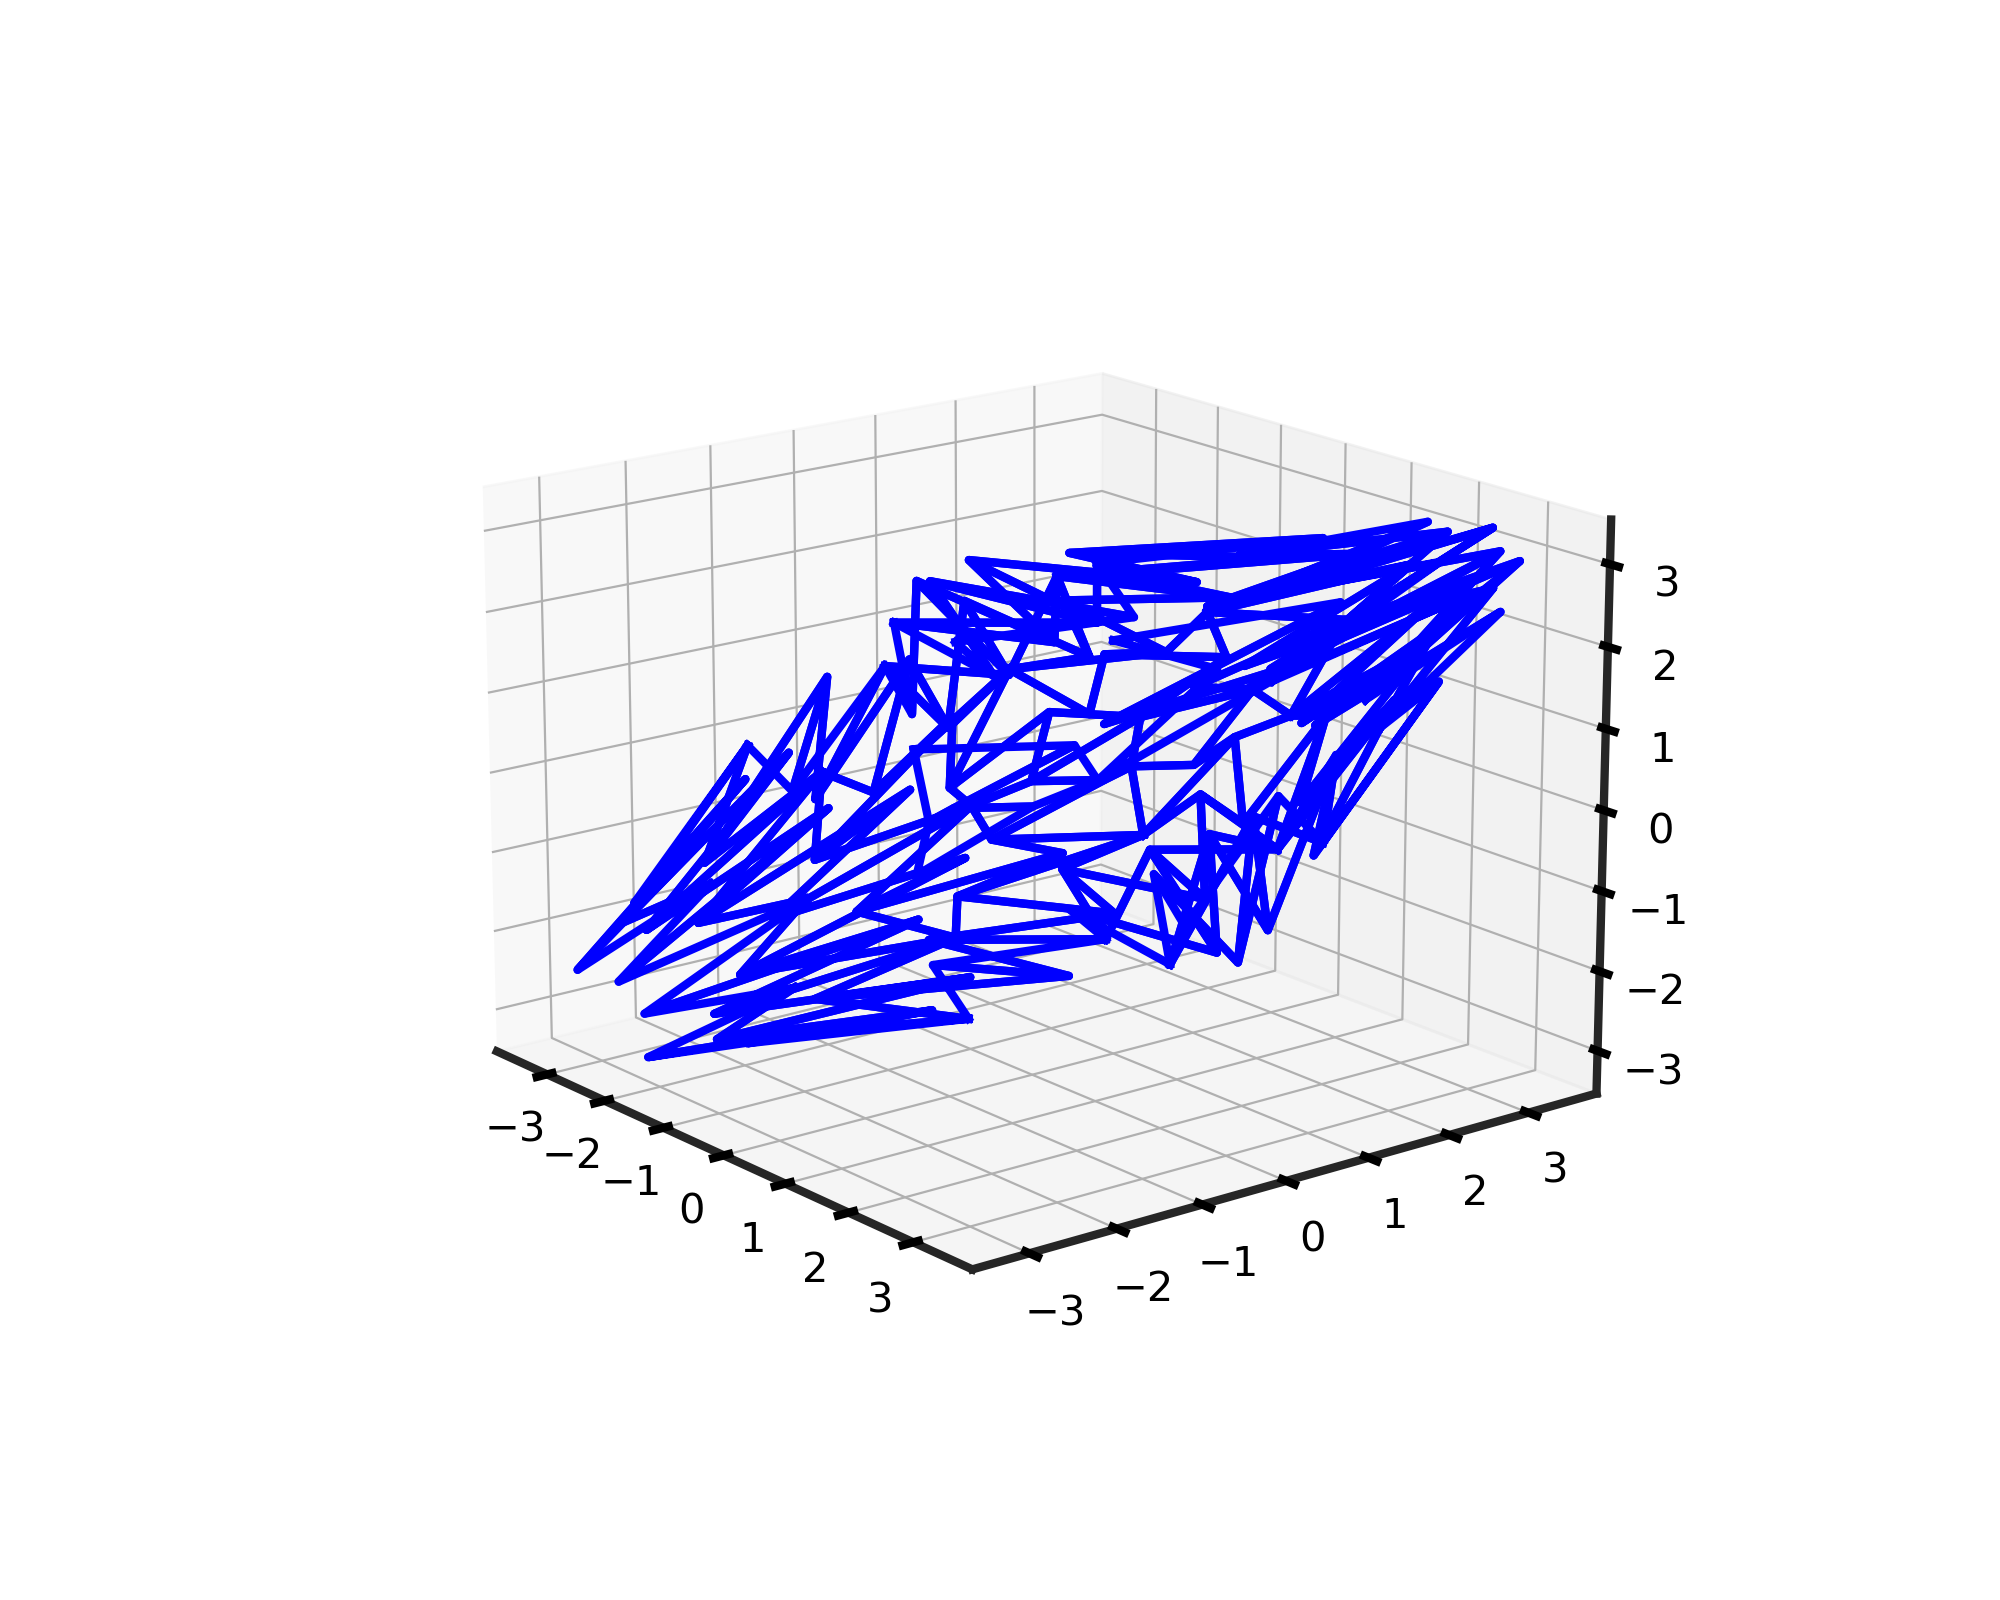

In [49]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

 
for facenum in range(len(new_faces)):
    curr_face = new_faces[facenum]
    xcurr = []
    ycurr = []
    zcurr = []
    for pointnum in range(len(curr_face)):
        xcurr.append(newPoints[curr_face[pointnum]][0])
        ycurr.append(newPoints[curr_face[pointnum]][1])
        zcurr.append(newPoints[curr_face[pointnum]][2])
    xcurr.append(newPoints[curr_face[0]][0])
    ycurr.append(newPoints[curr_face[0]][1])
    zcurr.append(newPoints[curr_face[0]][2])
 
    ax.plot(xcurr,ycurr,zcurr,color='b')
 
plt.show()

<IPython.core.display.Javascript object>


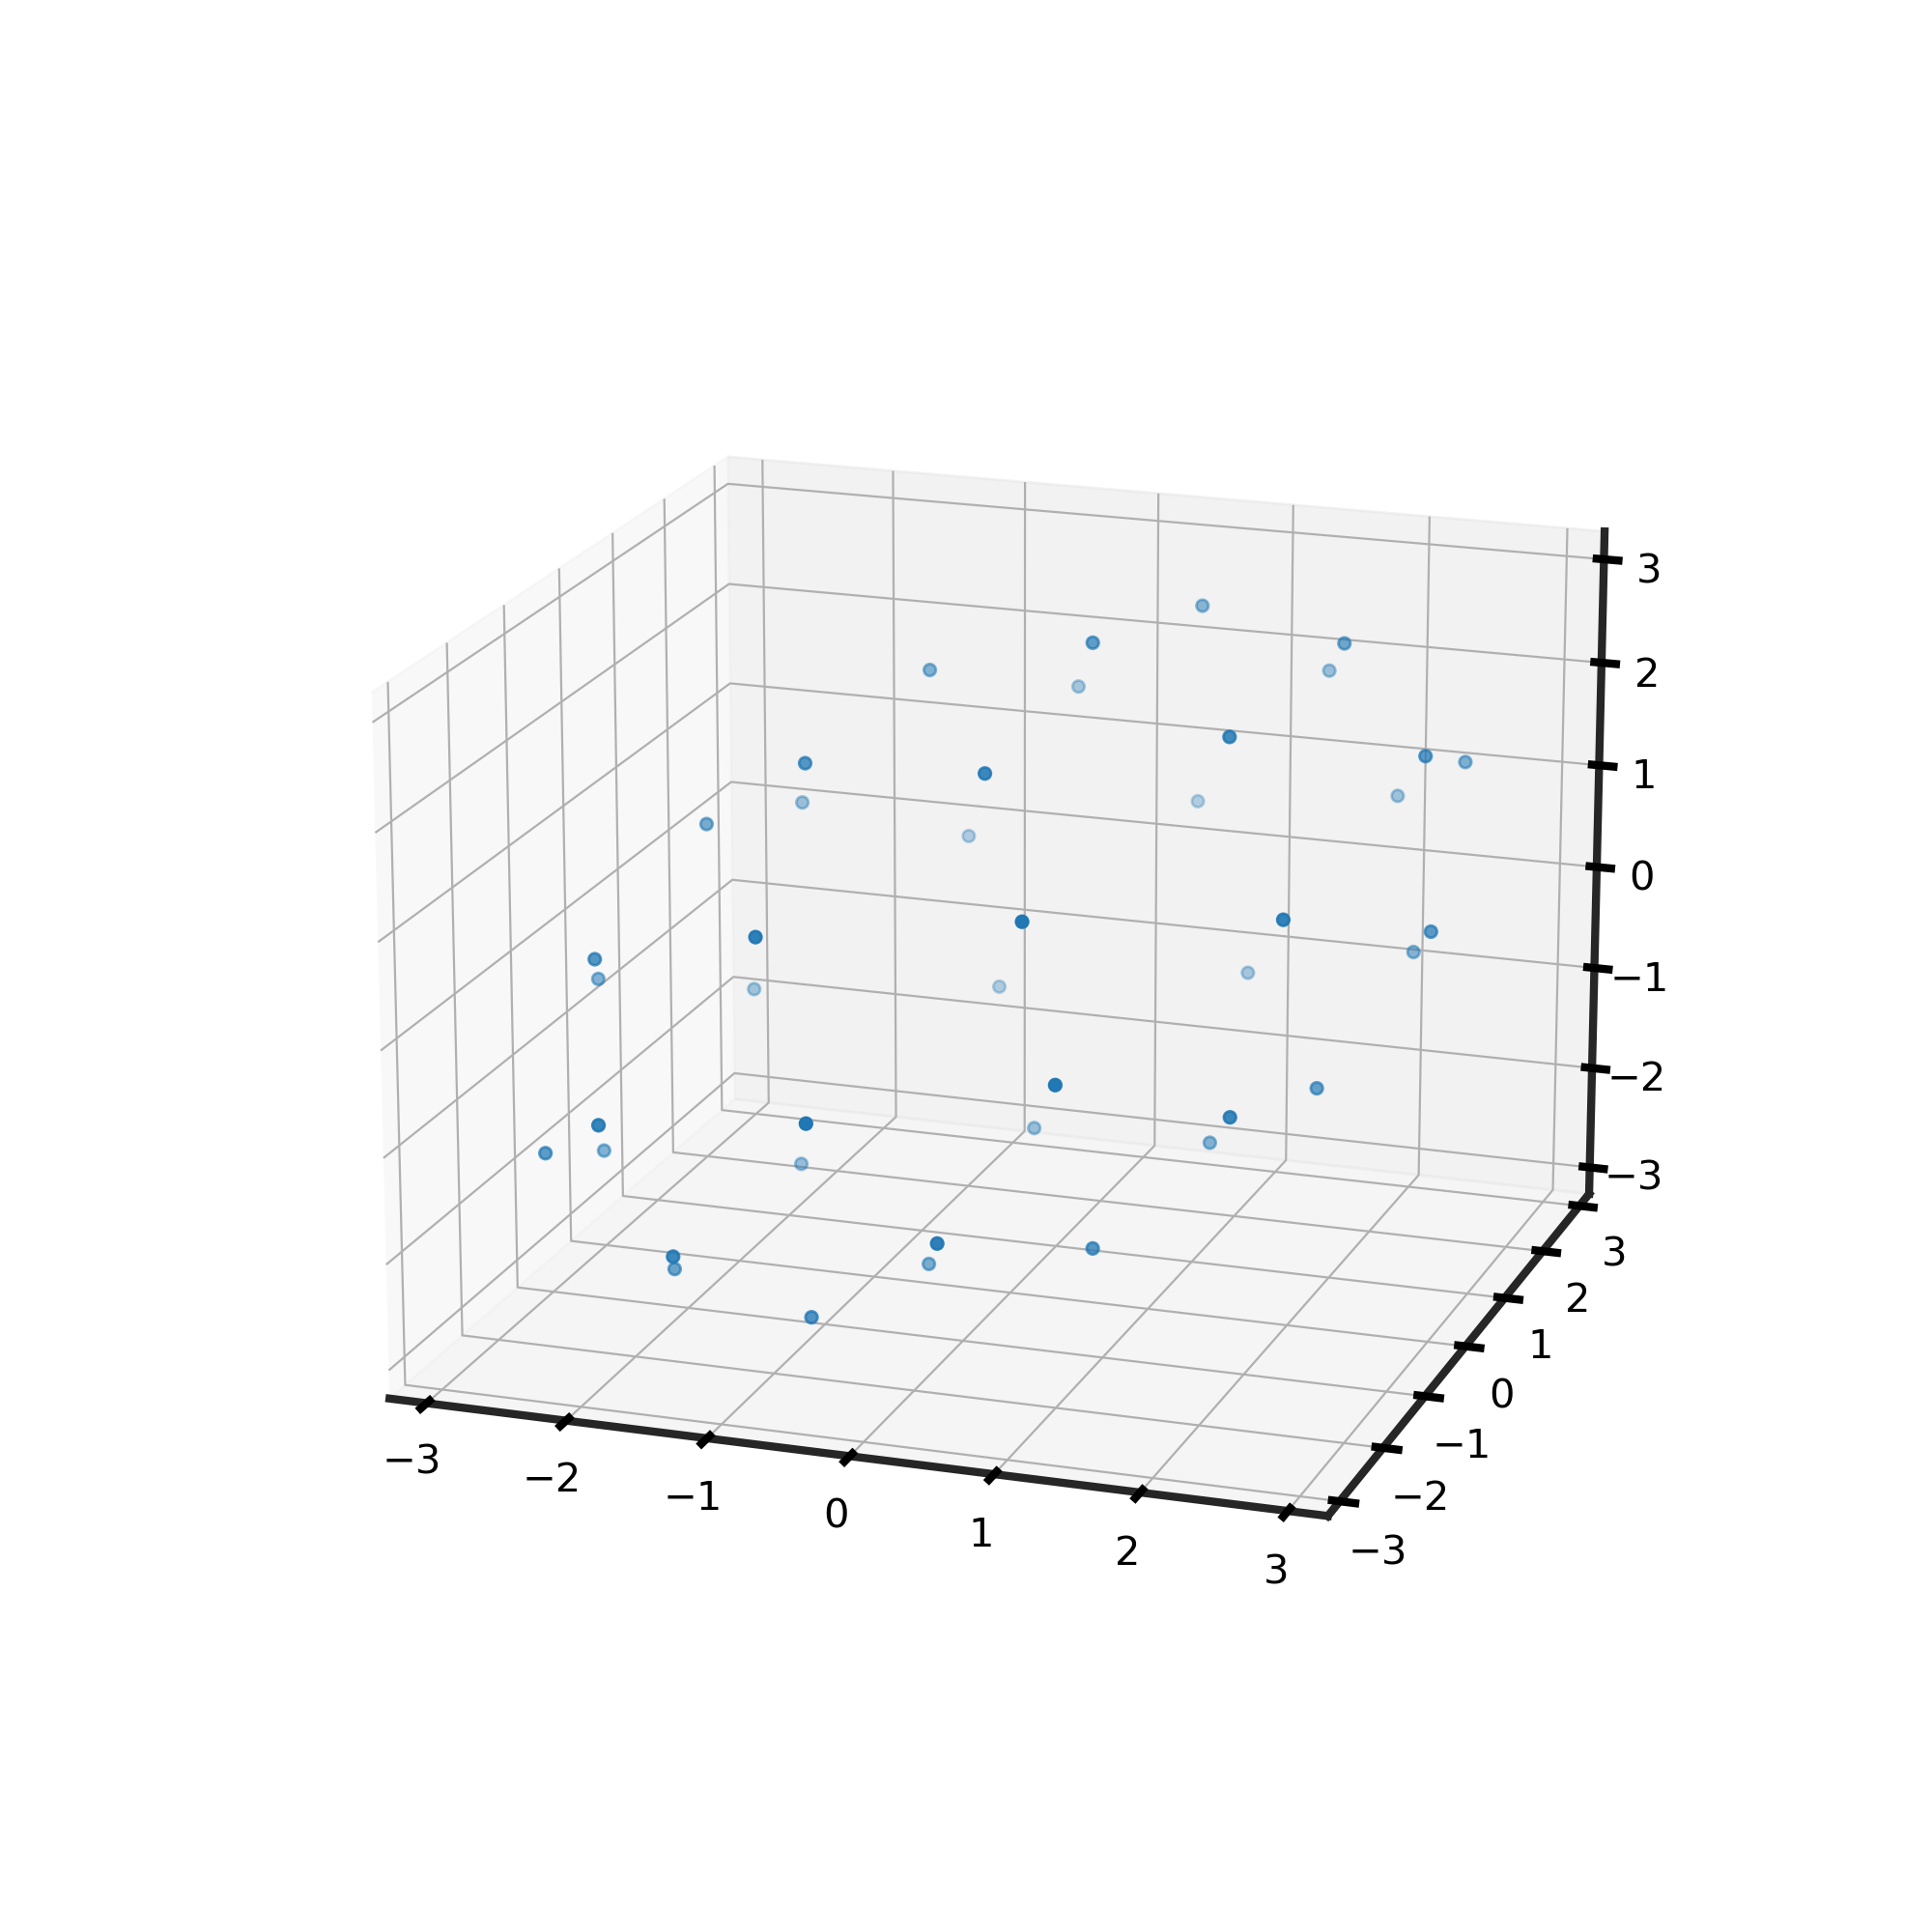

In [27]:
fig = plt.figure(figsize=(10,10))
ax  = fig.add_subplot(111, projection='3d')
ax.scatter(newPoints[:,0],newPoints[:,1],newPoints[:,2])

In [58]:
pos[:,0,:] - pos[:,1,:]

array([[-0.289412,  0.210267, -0.021405],
       [ 0.144922, -0.105291,  0.310396],
       [ 0.110543,  0.340223, -0.021405],
       ...,
       [-0.19726 ,  0.143316, -0.320502],
       [-0.2947  , -0.233655, -0.106945],
       [-0.144922,  0.105291, -0.310396]])